##Modelo BERT com dataset original (Dataset 70% para treinamento, 15% para teste e 15% para validação)

In [ ]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 106.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 106.2 MB/s eta 0:00:00


##Imports

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "drive/MyDrive/Mestrado/defesa/data/70-15-15"
model_path = "drive/MyDrive/Mestrado/defesa/models"

Mounted at /content/drive


In [ ]:
dataset = load_dataset("csv", data_files={"train":data_path+'/comunic_treino.csv', "test": data_path+'/comunic_teste.csv', "validation":data_path+'/comunic_valid.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-72fc5c1f69992a5c/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

def preprocess_data(docs):
    text = docs["text"]
    return tokenizer(docs["text"], padding='max_length', max_length=512, truncation=True)

In [ ]:
encoded_dataset = dataset.map(preprocess_data, batched=True) #,remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/1131 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

In [ ]:
encoded_dataset.set_format("torch")

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("neuralmind/bert-base-portuguese-cased", num_labels=13)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [ ]:
batch_size = 16
metric_name = "f1"

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

args = TrainingArguments(
    f"bert-finetuned-comunicados",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit = 5,
    learning_rate=1.362e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=30,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, hamming_loss
def compute_metrics(p):    
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}    

In [ ]:
from torch import nn
from transformers import Trainer

# the model is waiting for "labels", not "label"
encoded_dataset = encoded_dataset.rename_column("label", "labels")

# Get training encoded data into DataFrame
df = encoded_dataset["train"].to_pandas()

# Get a vector of weights (lowest weight for majority class)
class_weights = (1 - (df["labels"].value_counts().sort_index() / len(df))).values
print(class_weights)
# Put the weights vector to cuda as a Pytorch tensor
class_weights = torch.from_numpy(class_weights).float().to("cuda")

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # define loss function with calss weights
        loss_func = nn.CrossEntropyLoss() #weight=class_weights)
        # Compute loss
        loss = loss_func(logits, labels)
        return (loss, outputs) if return_outputs else loss


[0.9372237  0.92838196 0.98496905 0.96905393 0.52961981 0.96374889
 0.98231653 0.94341291 0.98585323 0.90981432 0.97259063 0.98231653
 0.9106985 ]


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1131
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2130
  Number of trainable parameters = 108933133


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.353919,0.592593,0.501364,0.592593,0.503662
2,No log,0.998784,0.753086,0.678962,0.753086,0.698638
3,No log,0.795865,0.781893,0.731966,0.781893,0.744041
4,No log,0.705818,0.814815,0.792876,0.814815,0.790482
5,No log,0.666491,0.802469,0.799570,0.802469,0.788595
6,No log,0.661478,0.855967,0.855255,0.855967,0.845208
7,No log,0.707382,0.823045,0.820159,0.823045,0.811114
8,0.743000,0.661854,0.839506,0.835907,0.839506,0.829553
9,0.743000,0.663697,0.851852,0.849283,0.851852,0.844543


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 243
  Batch size = 16
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to bert-finetuned-comunicados/checkpoint-71
Configuration saved in bert-finetuned-comunicados/checkpoint-71/config.json
Model weights saved in bert-finetuned-comunicados/checkpoint-71/pytorch_model.bin
tokenizer config file saved in bert-finetuned-comunicados/checkpoint-71/tokenizer_config.json
Special tokens file saved in bert-finetuned-comunicado

TrainOutput(global_step=639, training_loss=0.6051706573772878, metrics={'train_runtime': 1038.5136, 'train_samples_per_second': 32.672, 'train_steps_per_second': 2.051, 'total_flos': 2678471944492032.0, 'train_loss': 0.6051706573772878, 'epoch': 9.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 243
  Batch size = 16


{'eval_loss': 0.6614784002304077,
 'eval_accuracy': 0.8559670781893004,
 'eval_precision': 0.8552551266012038,
 'eval_recall': 0.8559670781893004,
 'eval_f1': 0.8452077882972192,
 'eval_runtime': 8.1703,
 'eval_samples_per_second': 29.742,
 'eval_steps_per_second': 1.958,
 'epoch': 9.0}

###Avaliação do modelo

In [ ]:
# Define test trainer
#test_trainer = Trainer(modelo_carregador) 
# Make prediction
#raw_pred, y_true, _ = test_trainer.predict(encoded_dataset['test']) 
# Preprocess raw predictions
#y_pred = np.argmax(raw_pred, axis=1)

In [ ]:
y_pred, y_true, _ = trainer.predict(encoded_dataset['test']) #encoded_dataset['validation']
y_pred = np.argmax(y_pred, axis=1)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 243
  Batch size = 16


In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.68      0.83      0.75        18
           2       0.00      0.00      0.00         3
           3       1.00      0.71      0.83         7
           4       0.93      0.98      0.96       114
           5       0.80      0.89      0.84         9
           6       1.00      0.75      0.86         4
           7       0.71      0.36      0.48        14
           8       0.80      1.00      0.89         4
           9       0.67      0.82      0.73        22
          10       0.50      0.29      0.36         7
          11       1.00      0.75      0.86         4
          12       0.90      0.82      0.86        22

    accuracy                           0.85       243
   macro avg       0.76      0.70      0.72       243
weighted avg       0.84      0.85      0.84       243



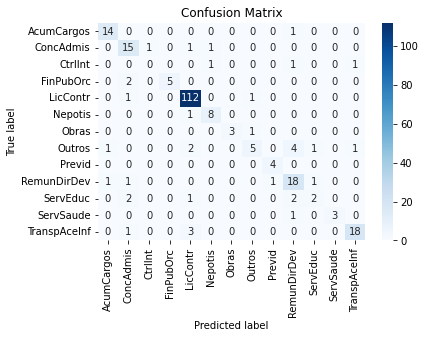

In [ ]:
%matplotlib inline  
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
import tensorflow as tf
labels = ['AcumCargos', 'ConcAdmis', 'CtrlInt', 'FinPubOrc', 'LicContr', 'Nepotis', 'Obras', 'Outros', 'Previd', 'RemunDirDev', 'ServEduc', 'ServSaude', 'TranspAceInf']

def visualize_confusion_matrix(y_pred_argmax, y_true):
    cm = tf.math.confusion_matrix(y_pred_argmax, y_true).numpy()
    con_mat_df = pd.DataFrame(cm)
    #con_mat_df = con_mat_df.drop(columns=con_mat_df.columns[0])
    #con_mat_df = con_mat_df.drop(columns=con_mat_df.columns[3])
    #con_mat_df = con_mat_df.drop(labels=[0,4], axis=0)
    con_mat_df.columns = labels
    con_mat_df.set_axis(labels, axis='index', inplace=True)

    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Blues)
    #plt.tight_layout()
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

visualize_confusion_matrix(y_true, y_pred)

In [ ]:
!pip install transformers_interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.8/793.8 KB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: ipython
    Found existing installation: ipython 7.9.0
    Uninstalling ipython-7.9.0:
      Successfully uninstalled ipython-7.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 7.34.0 which is incompatible.


In [ ]:
#trainer.save_model(model_path+"/BERT_70-15-15.mod")
from transformers import AutoModelForSequenceClassification
modelo_carregador = AutoModelForSequenceClassification.from_pretrained(model_path+"/BERT_70-15-15.mod")

loading configuration file drive/MyDrive/Mestrado/defesa/models/BERT_70-15-15.mod/config.json
Model config BertConfig {
  "_name_or_path": "drive/MyDrive/Mestrado/defesa/models/BERT_70-15-15.mod",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    

In [ ]:
from transformers_interpret import SequenceClassificationExplainer
df=pd.DataFrame(dataset['test'])
df.iloc[19].text

'o denunciativo compareceu a esta ouvidoria para comunicar que a esposa do prefeito da cidade de prata tem a posse de um veiculo wv placa piw renavan que é de propriedade do pai do dono da empresa que presta serviço de transporte escolar e locação de um veiculo da marca toiota railux para prefeitura da cidade e que armazena prefeito armazena combustível no almoxarifado da prefeitura para abastecer os carros do transporte escolar no entendimento do denunciante os carros deveriam ser abastecidos pelo empresa contratada'

In [ ]:
comunic=pd.read_csv(data_path+'/comunic_teste.csv')
transp=comunic[comunic.label==1]
cls_explainer = SequenceClassificationExplainer(modelo_carregador, tokenizer)

for cada in transp["text"][:3].values:
    word_attributions = cls_explainer(cada)
    cls_explainer.visualize()


In [ ]:
checkpoint = 'roberta-large-mnli'

# LM settiungs
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

# set training arguments
batch_size=32

training_args = TrainingArguments(num_train_epochs=5,
                              weight_decay=0.1,
                              learning_rate=1e-5,
                              per_device_train_batch_size=batch_size,
                              per_device_eval_batch_size=batch_size,
                              output_dir="content/drive/My Drive/Projects/test-trainer")


metric4 = load_metric("f1")

# function to tokenize each dataset
def tokenize_function(example):
    return tokenizer(example["message"], example["hypothesis"], truncation=True)


# 5-fold cross validation loop
for train_index, test_index in cv.split(data, data['label']):

    # split into train and test regions based on index positions
    train_set, test_set = data.iloc[list(train_index)],data.iloc[list(test_index)]

    # split training set into train and validation sub-regions
    train_set, val_set = train_test_split(train_set, 
                                    stratify=train_set['label'], 
                                    test_size=0.10, random_state=42)

    # convert datasets to Dataset object and gather in dictionary
    train_dataset = Dataset.from_pandas(train_set, preserve_index=False)
    val_dataset = Dataset.from_pandas(val_set, preserve_index=False)
    test_dataset = Dataset.from_pandas(test_set, preserve_index=False)

    combined_dataset = DatasetDict({'train':train_dataset,
                                 'test': test_dataset,
                                 'val':val_dataset})

    # tokenize
    tokenized_datasets = combined_dataset.map(tokenize_function, batched=True)

    # instantiate trainer
    trainer = Trainer(
           model,
           training_args,
           train_dataset=tokenized_datasets["train"],
           eval_dataset=tokenized_datasets["val"],
           data_collator=data_collator,
           tokenizer=tokenizer)

    # train
    trainer.train()

    # get predictions
    predictions = trainer.predict(tokenized_datasets["test"])
    preds = np.argmax(predictions.predictions, axis=-1)

    print("F1 score ", metric4.compute(predictions=preds, 
                        references=predictions.label_ids, 
                        average='macro',pos_label=2))